In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
!mkdir /content/brats_data

In [3]:
!tar -xvf /content/BraTS2021_00495.tar -C /content/brats_data

./
./BraTS2021_00495_flair.nii.gz
./BraTS2021_00495_seg.nii.gz
./BraTS2021_00495_t1.nii.gz
./BraTS2021_00495_t1ce.nii.gz
./BraTS2021_00495_t2.nii.gz


In [4]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn.functional as F
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from torch.optim import Adam
import matplotlib.pyplot as plt

In [5]:
# Load a NIfTI file and return its data
def load_nii(file_path):
    return nib.load(file_path).get_fdata()

# Paths
data_path = "/content/brats_data"
case_id = "BraTS2021_00495"

# Load modalities and segmentation mask
modalities = ["flair", "t1", "t1ce", "t2"]
image = np.stack([load_nii(os.path.join(data_path, f"{case_id}_{mod}.nii.gz")) for mod in modalities], axis=-1)
mask = load_nii(os.path.join(data_path, f"{case_id}_seg.nii.gz"))

In [6]:
# Pad depth to the nearest multiple of 16
def pad_volume(volume, multiple=16):
    depth = volume.shape[2]
    target_depth = ((depth + multiple - 1) // multiple) * multiple  # Round up to nearest multiple of 16
    pad_size = target_depth - depth

    if volume.ndim == 4:  # (H, W, D, C)
        return np.pad(volume, ((0, 0), (0, 0), (0, pad_size), (0, 0)), mode="constant")
    elif volume.ndim == 3:  # (H, W, D)
        return np.pad(volume, ((0, 0), (0, 0), (0, pad_size)), mode="constant")
    else:
        raise ValueError(f"Unsupported volume dimensions: {volume.shape}")

# Apply padding
image = pad_volume(image)  # Shape (H, W, D, 4)
mask = pad_volume(mask)    # Shape (H, W, D)


In [7]:
# Normalize each modality independently
image = (image - np.mean(image, axis=(0, 1, 2))) / (np.std(image, axis=(0, 1, 2)) + 1e-8)

# Convert to PyTorch tensors
image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0)  # (B, C, H, W, D)
mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0)  # (B, H, W, D)

# Remap label 4 to 3 (BraTS uses labels 0, 1, 2, 4 → map 4 to 3)
mask[mask == 4] = 3

In [8]:
# One-hot encode the mask (3 tumor regions, ignoring background)
mask_one_hot = F.one_hot(mask, num_classes=4).permute(0, 4, 1, 2, 3)[:, 1:]  # (B, 3, H, W, D)

In [9]:
# Define U-Net model
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
)

In [10]:
# Loss function and optimizer
criterion = DiceLoss(softmax=True)
optimizer = Adam(model.parameters(), lr=1e-2)

In [11]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(image)
    loss = criterion(outputs, mask_one_hot)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/100, Loss: 0.9930
Epoch 2/100, Loss: 0.9899
Epoch 3/100, Loss: 0.9886
Epoch 4/100, Loss: 0.9869
Epoch 5/100, Loss: 0.9854
Epoch 6/100, Loss: 0.9834
Epoch 7/100, Loss: 0.9812
Epoch 8/100, Loss: 0.9790
Epoch 9/100, Loss: 0.9774
Epoch 10/100, Loss: 0.9756
Epoch 11/100, Loss: 0.9737
Epoch 12/100, Loss: 0.9719
Epoch 13/100, Loss: 0.9699
Epoch 14/100, Loss: 0.9681
Epoch 15/100, Loss: 0.9666
Epoch 16/100, Loss: 0.9657
Epoch 17/100, Loss: 0.9621
Epoch 18/100, Loss: 0.9619
Epoch 19/100, Loss: 0.9587
Epoch 20/100, Loss: 0.9577
Epoch 21/100, Loss: 0.9567
Epoch 22/100, Loss: 0.9529
Epoch 23/100, Loss: 0.9432
Epoch 24/100, Loss: 0.9418
Epoch 25/100, Loss: 0.9342
Epoch 26/100, Loss: 0.9382
Epoch 27/100, Loss: 0.9274
Epoch 28/100, Loss: 0.9264
Epoch 29/100, Loss: 0.9165
Epoch 30/100, Loss: 0.9165
Epoch 31/100, Loss: 0.9032
Epoch 32/100, Loss: 0.9024
Epoch 33/100, Loss: 0.8998
Epoch 34/100, Loss: 0.8869
Epoch 35/100, Loss: 0.8772
Epoch 36/100, Loss: 0.8678
Epoch 37/100, Loss: 0.8618
Epoch 38/1

In [12]:
# Evaluate model
model.eval()
with torch.no_grad():
    output = model(image)

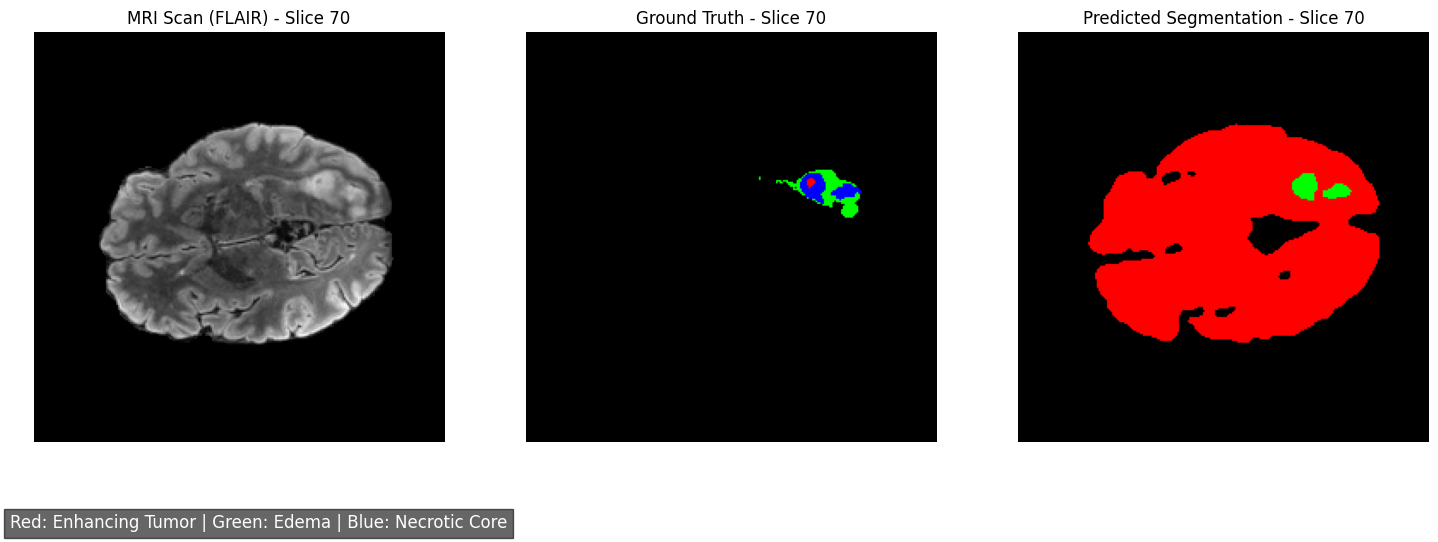

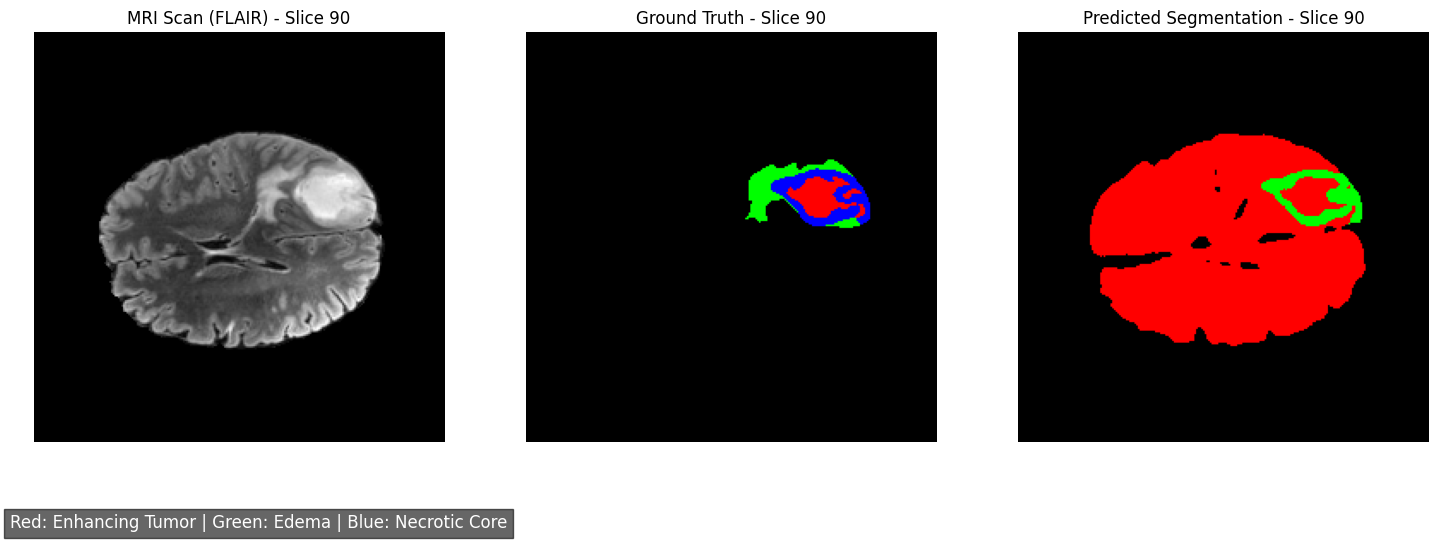

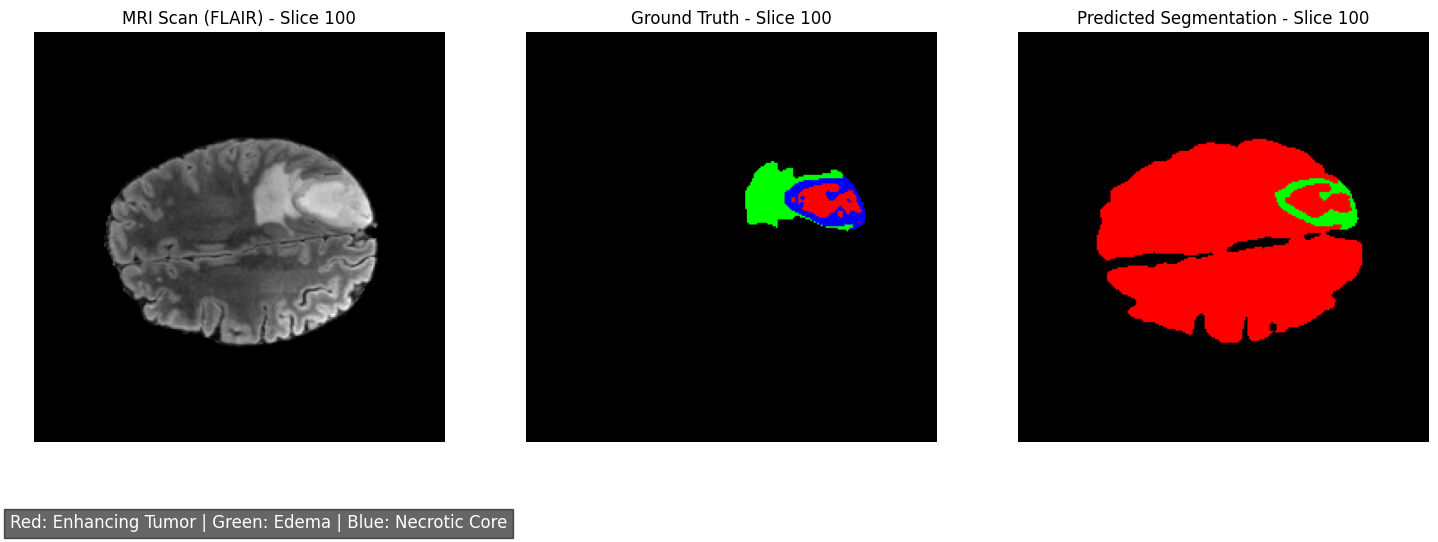

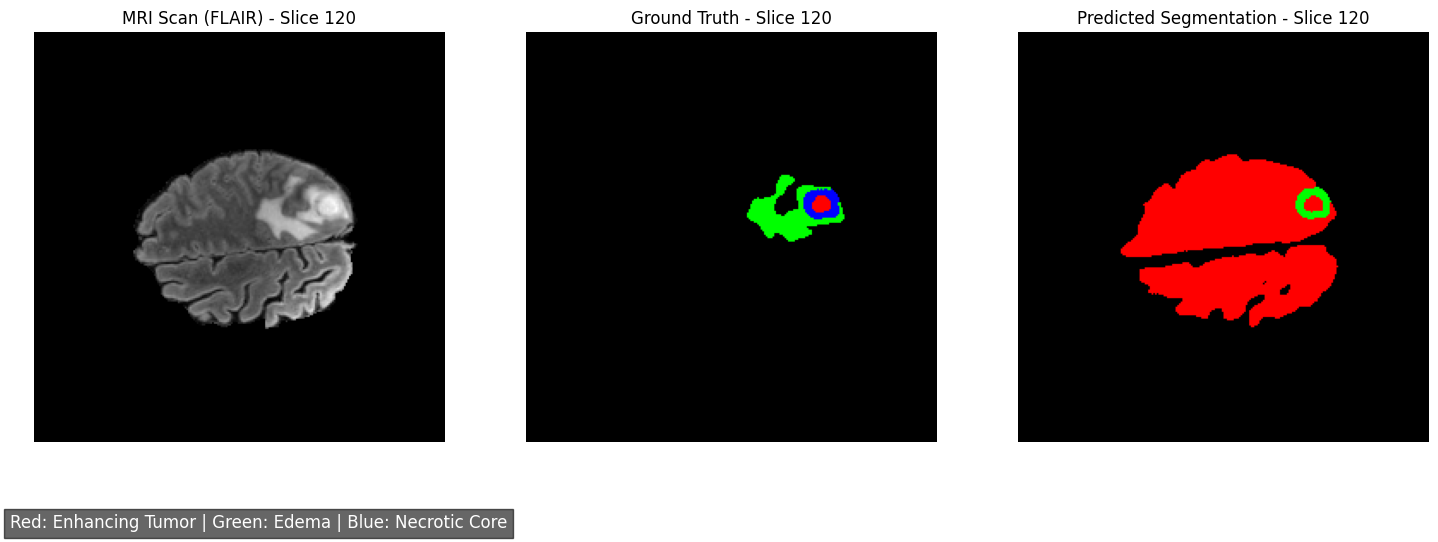

In [13]:
# Define color mapping for tumor regions
colors = {
    1: (255, 0, 0),   # Enhancing tumor (Red)
    2: (0, 255, 0),   # Edema (Green)
    3: (0, 0, 255),   # Necrotic core (Blue)
}

# Extract the predicted segmentation mask
pred_mask = torch.argmax(output, dim=1).cpu().numpy()[0]  # Convert to NumPy

# Define the list of slices for visualization
slice_idx_list = [70, 90, 100, 120]

# Create a function to generate color-coded masks
def create_colored_mask(segmentation):
    h, w = segmentation.shape
    colored_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label, color in colors.items():
        colored_mask[segmentation == label] = color
    return colored_mask

# Plot for each slice in the list
for slice_idx in slice_idx_list:
    # Get the corresponding ground truth and predicted slices
    ground_truth_slice = mask[0, :, :, slice_idx].cpu().numpy()
    predicted_slice = pred_mask[:, :, slice_idx]

    # Generate overlay images
    gt_colored = create_colored_mask(ground_truth_slice)
    pred_colored = create_colored_mask(predicted_slice)

    # Plot original MRI and segmentation results
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"MRI Scan (FLAIR) - Slice {slice_idx}")
    plt.imshow(image[0, 0, :, :, slice_idx].cpu().numpy(), cmap="gray")  # Using FLAIR for visualization
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"Ground Truth - Slice {slice_idx}")
    plt.imshow(gt_colored)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"Predicted Segmentation - Slice {slice_idx}")
    plt.imshow(pred_colored)
    plt.axis("off")


    plt.figtext(0.25, 0.01, "Red: Enhancing Tumor | Green: Edema | Blue: Necrotic Core", fontsize=12, ha="center", color="white", bbox=dict(facecolor="black", alpha=0.6))
    plt.show()


In [14]:
# Save model
torch.save(model.state_dict(), "unet_brats.pth")